In [14]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 384 (delta 124), reused 101 (delta 67), pack-reused 163
Receiving objects: 100% (384/384), 55.90 MiB | 8.06 MiB/s, done.
Resolving deltas: 100% (181/181), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=27640 sha256=b4de2f6acdc5af681d2468da722499c4103b694a81d3861ca90ae64944920958
  Stored in directory: /tmp/pip-ephem-wheel-cache-r11t2w5o/wheels/55/59/29/0fb1c6356521

In [15]:
from dul_2021.utils.hw12_utils import *

# Question 1. VAT

Here we will implement [VAT](https://arxiv.org/pdf/1704.03976.pdf).

* Train labeled data with standatd cross-entropy loss

* Use vat regularization for both unlabeled and labeled data

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* ξ= 10 
* lr = 5e-4
* num_epochs = 15



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [16]:
import torch.nn as nn
import torch
from torch.optim import Adam
from tqdm import tqdm
import numpy as np
from torchvision import transforms
import torch.nn.functional as F
import copy
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [17]:
class Net(nn.Module):
    def __init__(self, n_classes=10, out_dim=128, hid_dim_full=128):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)

        self.conv_to_fc = 8 * 8 * 4
        self.fc1 = nn.Linear(self.conv_to_fc, hid_dim_full)
        self.fc2 = nn.Linear(hid_dim_full, int(hid_dim_full // 2))

        self.features = nn.Linear(int(hid_dim_full // 2), out_dim)
        self.last = nn.Linear(out_dim, n_classes)


    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        x = x.view(-1, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        features = self.features(x)

        return self.last(features)

In [32]:
class VAT(nn.Module): 
    def __init__(self, n_classes=10, ksi=10, alpha=1):
        super().__init__()
        self.model = Net(n_classes=n_classes)

        self.ksi = ksi
        self.alpha = alpha

    def forward(self, batch):
        return self.model(batch)

    def labeled_loss(self, x, y):
        mask = (y == -1)
        x, y = x[~mask], y[~mask]
        y_pred = self.model(x)
        loss = F.cross_entropy(y_pred, y, reduction="none").mean()
        return loss

    def unlabeled_loss(self, x):
        with torch.no_grad():
            out = F.log_softmax(self.model(x), dim=1)

        r_adv = self.ksi * F.normalize(torch.randn(x.shape).to(device), dim=(1,2,3))
        r_adv.requires_grad_()

        log_p = F.log_softmax(self.model(x+r_adv), dim=1)
        dist = F.kl_div(log_p, out, reduction="batchmean")
        r_adv = F.normalize(torch.autograd.grad(dist, r_adv)[0], dim=(1, 2, 3))
        
        self.model.zero_grad()
        log_p = F.log_softmax(self.model(x+r_adv), dim=1)
        loss = F.kl_div(log_p, out, reduction="batchmean")

        return loss.mean()

    def loss(self, x, y):
        labeled = self.labeled_loss(x, y)
        unlabeled = self.unlabeled_loss(x)
        loss = labeled + self.alpha * unlabeled
        return loss
        

In [39]:
device = 'cuda'

def accuracy(model, test_loader):
    model.eval()
    acc = 0
    total = 0
    for x, y in iter(test_loader):
        mask = (y != -1)
        x = x.to(device)
        y = y.to(device).long()
        y_pred = torch.argmax(model(x[mask]), dim=1)
        acc += (y_pred == y[mask]).sum()
        total += x[mask].shape[0]
    model.train()
    return acc / total

def train(model, train_data, test_data, epochs=15, lr=1e-3, bs=128):
    opt = Adam(model.parameters(), lr=lr)
    dataloader = DataLoader(train_data, batch_size=bs, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=bs)
    model.train()
    losses = []
    accs = []

    for epoch in tqdm(range(epochs)):
        for x, y in iter(dataloader):
            x = x.to(device)
            y = y.to(device)

            loss = model.loss(x, y)
            opt.zero_grad()
            loss.backward()
            opt.step()

            losses.append(loss.item())
        accs.append(accuracy(model, test_dataloader).item())

    return np.array(losses), np.array(accs)

In [46]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """

    model = VAT()
    model.to(device)

    losses, accs = train(model, train_data, test_data, epochs=10, lr=5e-4)
    return losses, accs

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 10/10 [06:44<00:00, 40.42s/it]


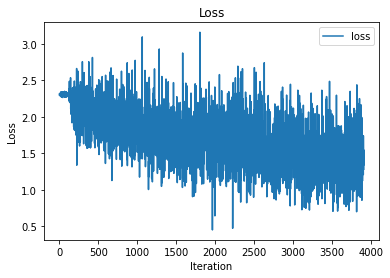

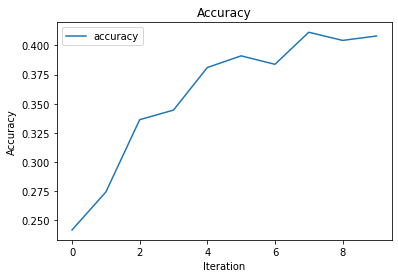

In [47]:
q12_results(q1)

# Question 2. FixMatch

Here we will implement [FixMatch](https://arxiv.org/abs/2001.07685).

* Calculate loss on weakly augmented labeled data with standatd cross-entropy loss

* Calculate loss on strongly augmented unlabeled data with standatd cross-entropy loss with pseudo-lables

* Use SimCLR transformations as strong and RandomHorizontalFlip as weak

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* τ = 0.7 
* λ_u = 10 (weight of unlabeled loss)
* lr = 5e-4
* num_epochs ~ 20 or more



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [48]:
from torchvision import transforms

In [57]:
class FixMatch(nn.Module):
    def __init__(self, tau=0.7, mu=10):
        super().__init__()
        self.tau = tau
        self.mu = mu
        self.model = Net()
        self.weak = transforms.RandomHorizontalFlip()
        self.strong = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=32),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5, 
                                                                     contrast=0.5, 
                                                                     saturation=0.5, 
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

    def forward(self, x):
        return self.model(x)

    def loss(self, x, y):
        mask = (y != -1)
        y_pred_strong = self.model(self.strong(x))
        strong_aug_loss = F.cross_entropy(y_pred_strong[mask], y[mask])

        y_pred_weak = self.model(self.weak(x[~mask]))
        y_pred_weak = F.softmax(y_pred_weak, dim=-1)
        values, labels = torch.max(y_pred_weak, dim=-1)
        mask_tau = (values > self.tau)
        weak_aug_loss = F.cross_entropy(y_pred_strong[~mask][mask_tau], labels[mask_tau])

        return strong_aug_loss + 1 / self.mu * weak_aug_loss


In [58]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """
    model = FixMatch()
    model.to(device)

    losses, accs = train(model, train_data, test_data, epochs=10, lr=5e-4)
    return losses, accs

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 10/10 [04:49<00:00, 28.96s/it]


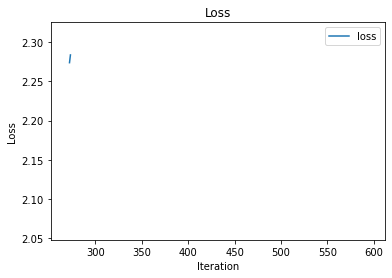

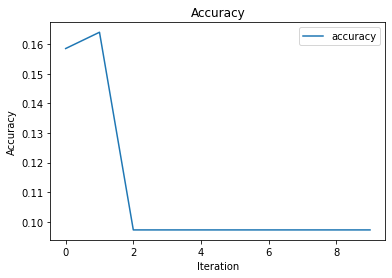

In [59]:
q12_results(q2)

# Bonus

## The probabilistic model

*(this is a short summary of the model presented in ["Semi-supervised Learning with
Deep Generative Models"](https://arxiv.org/pdf/1406.5298.pdf))*

In the semi-supervised setting, the generative model is a little more complicated than vanilla VAE. In particular, it incorporates a new variable $y$ that represents the class of a digit $x$.

\begin{align*}
& p(x, y, z) = p(x \mid y, z) p(z) p(y) \\
& p(y) = Cat(y \mid \pi_0), \pi_0 = (1/10, \dots, 1/10) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid y, z) = \prod_{i=1}^D p_i(y, z)^{x_i} (1 - p_i(y, z))^{1 - x_i}
\end{align*}

## The first part of the objective

Whenever we train a probabilistic model with partial observations, we interpret the unobserved variables as latent variables. Then we marginalize them. In this case, the loss function splits into two terms: one for observed variables (we denote the set of indices of observed labels $P$), another for unobserved.

\begin{equation}
L(X, y) = \sum_{i \notin P} \log p(x_i) + \sum_{i \in P} \log p(x_i, y_i)
\end{equation}

Again, we can't compute the exact values of marginal likelihoods and resort to variational lower bound on likelihood. To compute lower bounds, we define the following variational approximation:

\begin{align*}
& q(y, z \mid x) = q(y \mid x) q(z \mid y, x)\\
& \\
& q(y \mid x) = Cat(y \mid \pi(x))\\
& q(z \mid y, x) = \mathcal N(z \mid \mu_\phi(x, y), \operatorname{diag}\sigma^2_\phi(y, x))
\end{align*}

Using the variational approximation, we will obtain two lower bounds.

First, the ELBO for $\log p(x_i, y_i)$ for the observed variables (this one is similar to ELBO of VAE).

\begin{equation}
\log p(x, y) = \log \mathbb E_{p(z)} p(x, y \mid z) \geq \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x)}
\end{equation}

Second, the ELBO for $\log p(x_i)$ for the unobserved variables.

\begin{equation}
\log p(x) = \log \mathbb E_{p(y)} \mathbb E_{p(z \mid y)} \log p(x\mid z, y)\geq \mathbb E_{q(y \mid x)} \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x) q(y \mid x)}
\end{equation}

Finally, the joint lower bound will be

\begin{equation}
\mathcal L(X, y) = \sum_{i \in P} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i)} + \sum_{i \notin P} \mathbb E_{q(y_i \mid x_i)} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i) q(y_i \mid x_i)}
\end{equation}

We will use reparametrized Monte-Carlo estimates to approximate expectation w.r.t. $z$. To approximate expectaion w.r.t. the discrete variable $y$ we will try three different options.

In [ ]:
def b(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of binary MNIST images
    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """